# **Projekt 2**
## Katarzyna Mamla, Weronika Dyszkiewicz



In [ ]:
from google.colab import files
files.upload()

Import potrzebnych pakietów.

In [ ]:
import pandas as pd
import numpy as np
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as skm
import random

In [ ]:
X_train = pd.read_table('artificial_train.data', sep = '\s+', header = None, )
y_train = pd.read_table('artificial_train.labels', sep = '\s+', header = None)
X_test = pd.read_table('artificial_test.data', sep = '\s+', header = None)


In [ ]:
X_test.isna().sum().unique()

array([0])

Funkcja do zapisywania uzyskanych prawdopodobieństw w pliku .txt.

In [ ]:
def save_probs_to_txt(predictions, output_file_name):

    df=pd.DataFrame({'313482_313498':predictions})
    df.to_csv(output_file_name, sep='\t', index=False)

# Modele wykonane ręcznie

Preprocessing danych.

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

##Random Forest

1. Klasyfikacja przy użyciu RandomForestClassifier **bez selekcji zmiennych**

In [ ]:
clf =Pipeline([('scaler', StandardScaler()),
    ('classification', RandomForestClassifier(random_state=123))
    ])

param_grid = {
    'scaler': [StandardScaler(),  RobustScaler(),
     Normalizer(), MaxAbsScaler()],
    'classification__n_estimators': [i for i in range(50, 500, 25)],
    'classification__max_features': ['auto', 'sqrt', 'log2'],
    'classification__max_depth' : [1,5,10,25],
    'classification__criterion' :['gini', 'entropy']
}
k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

CV_clf_0 = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv= k_fold, scoring = 'balanced_accuracy',random_state=123)

CV_clf_0.fit(X_train, y_train)


In [ ]:
print(" Results from Random Search (without feature selection)" )
print("\n The best estimator across ALL searched params:\n", CV_clf_0.best_estimator_)
print("\n The best score across ALL searched params:\n", CV_clf_0.best_score_)
print("\n The best parameters across ALL searched params:\n", CV_clf_0.best_params_)

 Results from Random Search (without feature selection)

 The best estimator across ALL searched params:
 Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classification',
                 RandomForestClassifier(criterion='entropy', max_depth=25,
                                        n_estimators=250, random_state=123))])

 The best score across ALL searched params:
 0.6940308572045099

 The best parameters across ALL searched params:
 {'scaler': MaxAbsScaler(), 'classification__n_estimators': 250, 'classification__max_features': 'sqrt', 'classification__max_depth': 25, 'classification__criterion': 'entropy'}


Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classification',
                 RandomForestClassifier(criterion='entropy', max_depth=25,
                                        n_estimators=250, random_state=123))])


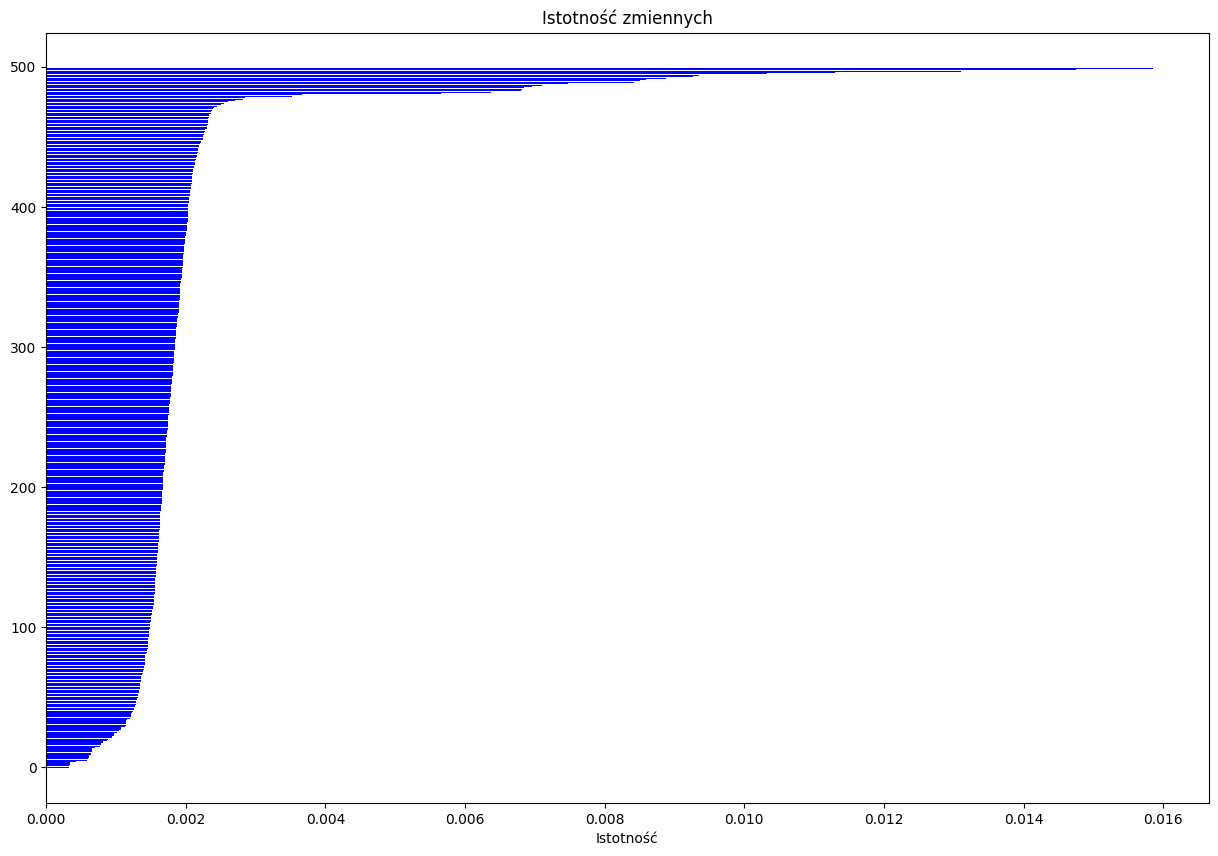

In [ ]:
xf=CV_clf_0.best_estimator_
print(xf)
final_classifier = xf.named_steps
importances=final_classifier['classification'].feature_importances_
indices = np.argsort(importances)


plt.figure(figsize=(15,10))
plt.title('Istotność zmiennych')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlabel('Istotność')
plt.show()


2. Klasyfikacja przy użyciu RandomForestClassifier **+ selekcja zmiennych korzystając z SelectFromModel.**


In [ ]:
clf =Pipeline([('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC())),
    ('classification', RandomForestClassifier(random_state=123))
    ])

param_grid = {
    'scaler': [StandardScaler(),  RobustScaler(),
     Normalizer(), MaxAbsScaler()],
    'classification__n_estimators': [i for i in range(50, 500, 25)],
    'classification__max_features': ['auto', 'sqrt', 'log2'],
    'classification__max_depth' : [1,5,10,25],
    'classification__criterion' :['gini', 'entropy']
}
k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

CV_clf = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv= k_fold, scoring = 'balanced_accuracy',random_state=123)

CV_clf.fit(X_train, y_train)


In [ ]:
y_prob=CV_clf.predict_proba(X_test)[:,1]


In [ ]:
print(" Results from Random Search (with feature selection) " )
print("\n The best estimator across ALL searched params:\n", CV_clf.best_estimator_)
print("\n The best score across ALL searched params:\n", CV_clf.best_score_)
print("\n The best parameters across ALL searched params:\n", CV_clf.best_params_)

 Results from Random Search (with feature selection) 

 The best estimator across ALL searched params:
 Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection', SelectFromModel(estimator=LinearSVC())),
                ('classification',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=175, random_state=123))])

 The best score across ALL searched params:
 0.7405114695533858

 The best parameters across ALL searched params:
 {'scaler': RobustScaler(), 'classification__n_estimators': 175, 'classification__max_features': 'sqrt', 'classification__max_depth': 10, 'classification__criterion': 'entropy'}


In [ ]:
xf=CV_clf.best_estimator_
final_classifier = xf.named_steps
print(xf)

Wybrane istotne kolumny

In [ ]:
final_classifier['feature_selection'].get_support()
col_names=final_classifier['feature_selection'].transform(
    np.arange(0,len(X_train.columns)).reshape(1,-1)
)
col_names

array([[  1,   4,   5,  10,  14,  18,  21,  23,  26,  28,  34,  38,  41,
         42,  44,  46,  47,  48,  49,  53,  54,  55,  56,  57,  60,  61,
         63,  64,  65,  73,  83,  85, 103, 105, 109, 119, 127, 128, 130,
        136, 137, 139, 140, 144, 152, 153, 154, 159, 161, 162, 163, 164,
        165, 167, 168, 179, 186, 196, 199, 200, 202, 204, 205, 207, 211,
        214, 216, 220, 221, 226, 227, 241, 245, 248, 253, 277, 278, 281,
        282, 285, 286, 291, 296, 298, 299, 301, 304, 306, 308, 309, 310,
        314, 317, 318, 323, 330, 333, 336, 338, 340, 343, 344, 348, 349,
        352, 357, 358, 363, 376, 377, 378, 382, 383, 384, 399, 403, 409,
        410, 411, 413, 414, 417, 419, 420, 422, 423, 424, 425, 430, 431,
        433, 440, 441, 442, 445, 448, 449, 451, 452, 453, 454, 457, 458,
        468, 469, 471, 472, 475, 480, 481, 486, 490, 493, 494, 496, 497]])

Liczba istotnych zmiennych objaśniających:

In [ ]:
col_names.shape[1]

156

Sprawdzenie:

In [ ]:
importances=final_classifier['classification'].feature_importances_
importances.sum()

1.0

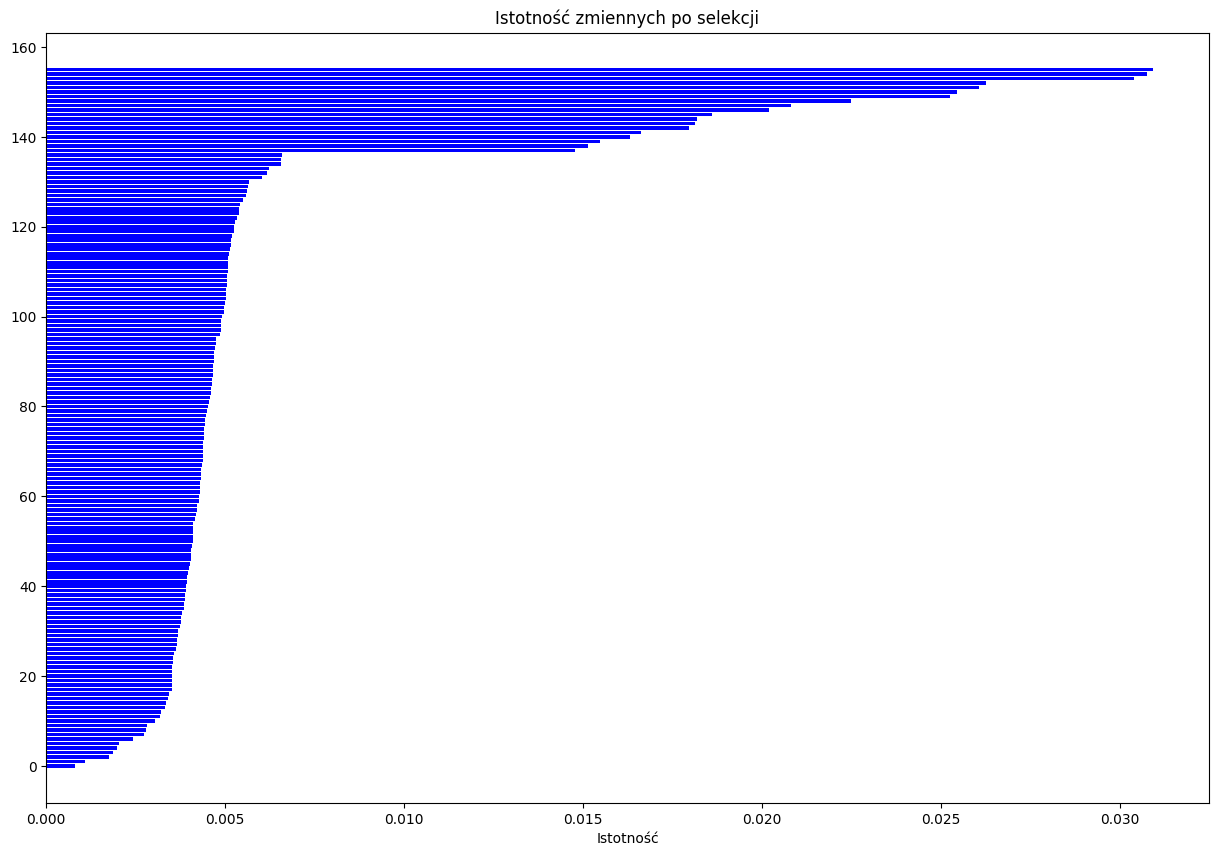

In [ ]:
indices = np.argsort(importances)

#plot results
plt.figure(figsize=(15,10))
plt.title('Istotność zmiennych po selekcji')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlabel('Istotność')
plt.show()

In [ ]:
save_probs_to_txt(y_prob, 'prob_rf_select.txt')

Wykres przedstawiający wartości hiperparametrów i odpowiednie dla nich mean scory:

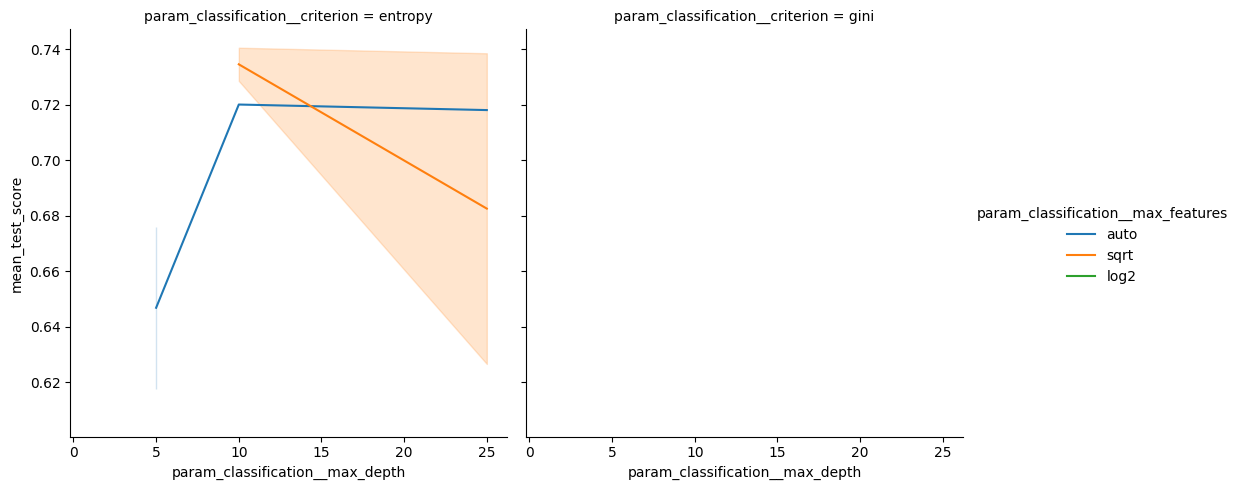

In [ ]:
result_df = DataFrame.from_dict(CV_clf.cv_results_, orient='columns')
sns.relplot(data=result_df,
 kind='line',
 x='param_classification__max_depth',
 y='mean_test_score',
 hue='param_classification__max_features',
 col='param_classification__criterion')
plt.show()

##KNN

In [ ]:
random.seed(123)
knn = KNeighborsClassifier()
knn_p =Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC())),
    ('classifier',knn)
    ])
parameters = {
    'scaler': [StandardScaler(), RobustScaler(),
 Normalizer(), MaxAbsScaler()],
 'classifier__n_neighbors': [1, 3, 5, 7, 10],
 'classifier__p': [1, 2],
 'classifier__leaf_size': [1, 5, 10, 15],
 'classifier__weights': ['uniform','distance']
}
kfold = skm.KFold(5, random_state=0,shuffle=True)

knn_pwei_cv = RandomizedSearchCV(estimator=knn_p, refit=True, param_distributions=parameters, cv= kfold, scoring = 'balanced_accuracy',random_state=123)

knn_pwei_cv.fit(X_train, y_train)

In [ ]:
print(" Results from KNN " )
#print("\n The best estimator across ALL searched params:\n", knn_pwei_cv.best_estimator_)
print("\n The best score across ALL searched params:\n", knn_pwei_cv.best_score_)
print("\n The best parameters across ALL searched params:\n", knn_pwei_cv.best_params_)

 Results from KNN 

 The best score across ALL searched params:
 0.7071556761688058

 The best parameters across ALL searched params:
 {'scaler': Normalizer(), 'classifier__weights': 'distance', 'classifier__p': 2, 'classifier__n_neighbors': 1, 'classifier__leaf_size': 5}


In [ ]:
knnp=knn_pwei_cv.best_estimator_
final_classifier_knn = knnp.named_steps

Istotne kolumny:

In [ ]:
final_classifier_knn['feature_selection'].get_support()
col_names=final_classifier_knn['feature_selection'].transform(
    np.arange(0,len(X_train.columns)).reshape(1,-1)
)
col_names

array([[  1,   4,   6,  10,  12,  18,  24,  26,  31,  41,  42,  43,  44,
         46,  48,  49,  54,  55,  56,  60,  64,  65,  66,  73,  85,  91,
         95, 105, 111, 114, 116, 119, 121, 125, 127, 128, 129, 130, 134,
        136, 137, 139, 140, 147, 149, 153, 155, 159, 164, 165, 172, 175,
        179, 184, 185, 186, 187, 188, 193, 199, 204, 211, 213, 216, 220,
        221, 223, 224, 226, 241, 243, 244, 245, 246, 251, 253, 255, 256,
        268, 277, 278, 279, 281, 282, 285, 286, 287, 294, 296, 298, 299,
        303, 304, 309, 313, 318, 321, 323, 329, 330, 333, 334, 336, 338,
        340, 343, 347, 348, 349, 352, 358, 359, 365, 370, 374, 375, 377,
        378, 379, 382, 384, 391, 397, 403, 410, 411, 412, 413, 414, 415,
        417, 418, 419, 424, 425, 430, 431, 432, 433, 434, 442, 443, 444,
        453, 455, 457, 458, 462, 463, 467, 468, 472, 475, 478, 481, 483,
        490, 493, 494]])

In [ ]:
col_names.shape[1]

159

Liczba istotnych kolumn:

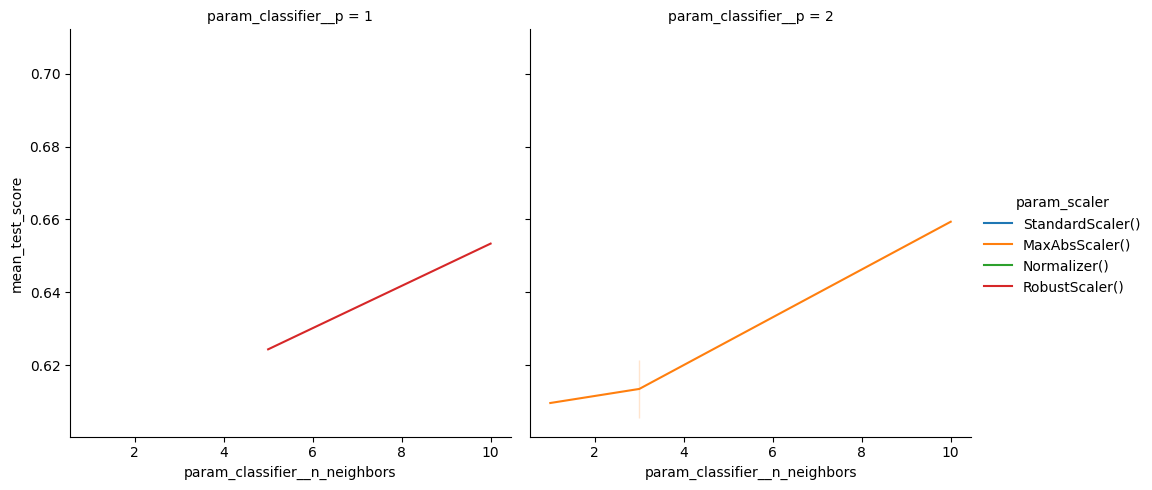

In [ ]:
result_df = DataFrame.from_dict(knn_pwei_cv.cv_results_, orient='columns')
sns.relplot(data=result_df,
 kind='line',
 x='param_classifier__n_neighbors',
 y='mean_test_score',
 hue='param_scaler',
 col='param_classifier__p')
plt.show()

In [ ]:
y_prob_kkn_select=knn_pwei_cv.predict_proba(X_test)[:,1]

In [ ]:
save_probs_to_txt(y_prob_kkn_select, 'prob_kkn_select.txt')

## XGB

In [ ]:
clf =Pipeline([('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC())),
    ('estimator', xgb.XGBClassifier(random_state=123))
    ])

param_grid = {
    'scaler': [StandardScaler(),  RobustScaler(),
     Normalizer(), MaxAbsScaler()],
    'estimator__n_estimators': [100, 400, 800],
    'estimator__max_depth': [3, 6, 9],
    'estimator__learning_rate': [0.05, 0.1, 0.20],
    'estimator__min_child_weight': [1, 10, 100]
}
k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

CV_clf_xgb = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv= k_fold, scoring = 'balanced_accuracy',random_state=123)

CV_clf_xgb.fit(X_train, y_train)


In [ ]:
print(" Results from Random Search for XGB " )
print("\n The best estimator across ALL searched params:\n", CV_clf_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n", CV_clf_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n", CV_clf_xgb.best_params_)

 Results from Random Search for XGB 

 The best estimator across ALL searched params:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectFromModel(estimator=LinearSVC())),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9

Liczba istotnych kolumn:

In [ ]:
xgbf=CV_clf_xgb.best_estimator_
final_classifier_xgb = xgbf.named_steps
final_classifier_xgb['feature_selection'].get_support()
col_names=final_classifier_xgb['feature_selection'].transform(
    np.arange(0,len(X_train.columns)).reshape(1,-1)
)
col_names
col_names.shape[1]

166

## 2 Selekcja zmiennych PCA()

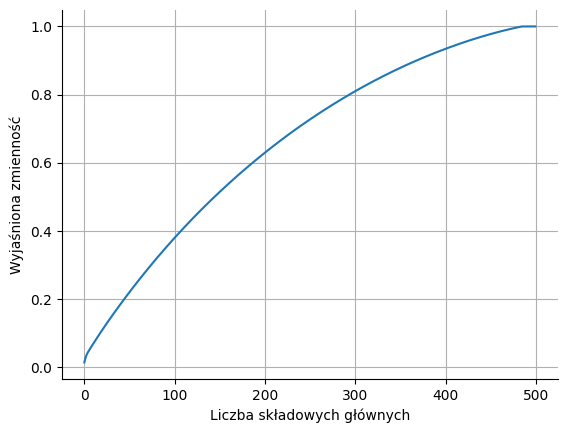

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
train_x_norm = scaler.transform(X_train)


pca = PCA()
comp = pca.fit(train_x_norm)

# jaki procent wariancji został wyjaśniony przez daną nowoutworzoną zmienną
# może to służyć do wyboru tylko części zmiennych, tych które wyjaśniają istotny procent wariancji
plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Liczba składowych głównych')
plt.ylabel('Wyjaśniona zmienność')
sns.despine()

In [ ]:
np.argwhere(np.cumsum(comp.explained_variance_ratio_)>0.99).min()

468

In [ ]:
np.max(comp.explained_variance_ratio_)

0.012926180022881697

In [ ]:
np.where(comp.explained_variance_ratio_>0.004)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),)

Text(0, 0.5, 'Wyjaśniona zmienność')

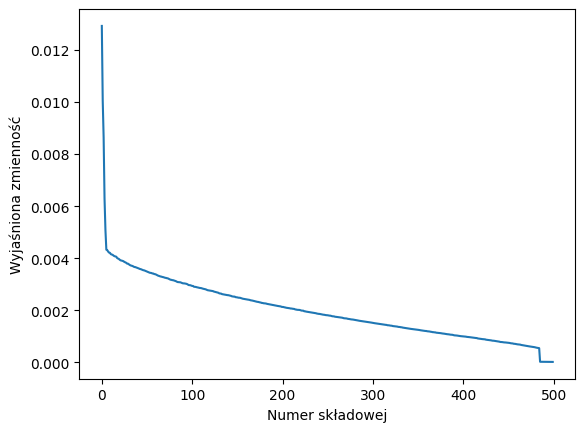

In [ ]:
plt.plot(comp.explained_variance_ratio_)
plt.xlabel('Numer składowej')
plt.ylabel('Wyjaśniona zmienność')

## Random Forest

In [ ]:
pca = PCA()
n_components = list(range(1,17,1))
rf_pca =Pipeline([
    ('scaler', StandardScaler()),
    ('selector', pca),
    ('estimator',RandomForestClassifier(random_state=123))
    ])
parameters = {
    'scaler': [StandardScaler(),  RobustScaler(),
     Normalizer(), MaxAbsScaler()],
     'selector__n_components': n_components,
    'estimator__n_estimators': [i for i in range(50, 500, 25)],
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__max_depth' : [1,5,10,25],
    'estimator__criterion' :['gini', 'entropy']
}

kfold = skm.KFold(5, random_state=0,shuffle=True)
rf_pca_cv = RandomizedSearchCV(estimator=rf_pca, refit=True, param_distributions=parameters, cv= kfold, scoring = 'balanced_accuracy', n_jobs=-1, n_iter=200)

rf_pca_cv.fit(X_train, y_train)

In [ ]:
print(" Results from RandomForestClassifier" )
#print("\n The best estimator across ALL searched params:\n", rf_pca_cv.best_estimator_)
print("\n The best score across ALL searched params:\n", rf_pca_cv.best_score_)
print("\n The best parameters across ALL searched params:\n", rf_pca_cv.best_params_)

 Results from RandomForestClassifier

 The best score across ALL searched params:
 0.8639295229817143

 The best parameters across ALL searched params:
 {'selector__n_components': 5, 'scaler': Normalizer(), 'estimator__n_estimators': 325, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 25, 'estimator__criterion': 'entropy'}


In [ ]:
xf_pca=rf_pca_cv.best_estimator_
final_classifier_pca = xf_pca.named_steps
model=final_classifier_pca['selector']
results=model.fit_transform(train_x_norm)

0.04294874885395008


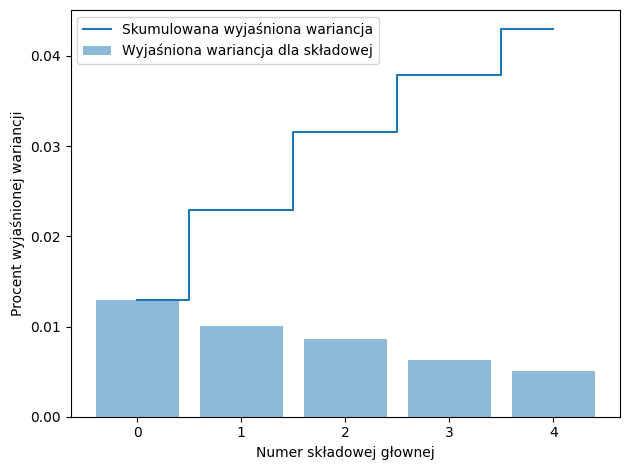

In [ ]:
exp_var_pca = model.explained_variance_ratio_
print(exp_var_pca.sum())
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Wyjaśniona wariancja dla składowej')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Skumulowana wyjaśniona wariancja')
plt.ylabel('Procent wyjaśnionej wariancji')
plt.xlabel('Numer składowej głownej')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
y_p=rf_pca_cv.predict_proba(X_test)

## XGBoost

In [ ]:
pca = PCA()

xgb_pca =Pipeline([
    ('scaler', StandardScaler()),
    ('selector', pca),
    ('estimator',xgb.XGBClassifier(random_state=123))
    ])
parameters = {
    'scaler': [StandardScaler(),  RobustScaler(),
 Normalizer(), MaxAbsScaler()],
    'selector__n_components': n_components,
    'estimator__n_estimators': [100, 400, 800],
    'estimator__max_depth': [3, 6, 9],
    'estimator__learning_rate': [0.05, 0.1, 0.20],
    'estimator__min_child_weight': [1, 10, 100]
}

xgb_pca_cv = RandomizedSearchCV(estimator=xgb_pca, refit=True, param_distributions=parameters, cv= kfold, scoring = 'balanced_accuracy', n_iter=400)

xgb_pca_cv.fit(X_train, y_train)

In [ ]:
print(" Results from XGBoost " )
#print("\n The best estimator across ALL searched params:\n", xgb_pca_cv.best_estimator_)
print("\n The best score across ALL searched params:\n", xgb_pca_cv.best_score_)
print("\n The best parameters across ALL searched params:\n", xgb_pca_cv.best_params_)

 Results from XGBoost 

 The best score across ALL searched params:
 0.8647974593607989

 The best parameters across ALL searched params:
 {'selector__n_components': 5, 'scaler': Normalizer(), 'estimator__n_estimators': 800, 'estimator__min_child_weight': 1, 'estimator__max_depth': 9, 'estimator__learning_rate': 0.05}


In [ ]:
opt_xgb = xgb.XGBClassifier(**xgb_pca_cv.best_params_)
opt_xgb.fit(X_train, y_train)

In [ ]:
xgb_pca=xgb_pca_cv.best_estimator_
final_classifier_xgb = xgb_pca.named_steps
model_xgb=final_classifier_xgb['selector']
results_xgb=model_xgb.fit_transform(train_x_norm)

0.04286188770382446


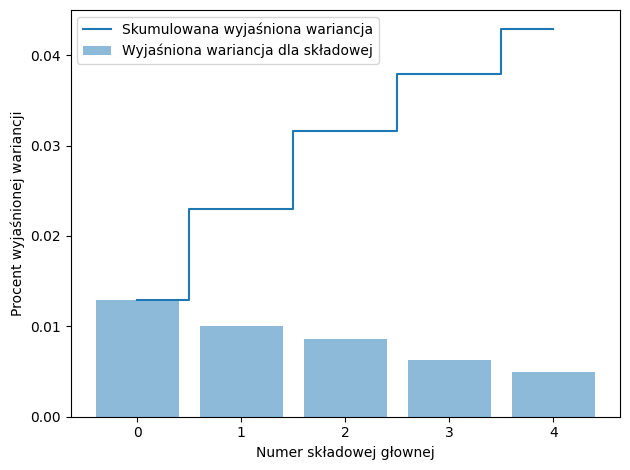

In [ ]:
exp_var_pca = model_xgb.explained_variance_ratio_
print(exp_var_pca.sum())
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Wyjaśniona wariancja dla składowej')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Skumulowana wyjaśniona wariancja')
plt.ylabel('Procent wyjaśnionej wariancji')
plt.xlabel('Numer składowej głownej')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
y_prob_xgb_pca=xgb_pca_cv.predict_proba(X_test)[:,1]

In [ ]:
save_probs_to_txt(y_prob_xgb_pca,'y_prob_xgb_pca.txt')

 ## KNN

In [ ]:
random.seed(123)
knn = KNeighborsClassifier()
pca = PCA()
n_components = list(range(1,18,1))
knn_pca =Pipeline([
    ('scaler', StandardScaler()),
    ('selector', pca),
    ('classifier',knn)
    ])
parameters = {
    'scaler': [StandardScaler(),  RobustScaler(),
 Normalizer(), MaxAbsScaler()],
  'selector__n_components': n_components,
 'classifier__n_neighbors': [1, 3, 5, 7, 10],
 'classifier__p': [1, 2],
 'classifier__leaf_size': [1, 5, 10, 15],
  'classifier__weights': ['uniform','distance']
}

knn_pca_cv = RandomizedSearchCV(estimator=knn_pca, refit=True, param_distributions=parameters, cv= kfold, scoring = 'balanced_accuracy',n_iter=200, n_jobs=-1)

knn_pca_cv.fit(X_train, y_train)

In [ ]:
print(" Results from KNN with PCA " )
#print("\n The best estimator across ALL searched params:\n", knn_pca_cv.best_estimator_)
print("\n The best score across ALL searched params:\n", knn_pca_cv.best_score_)
print("\n The best parameters across ALL searched params:\n", knn_pca_cv.best_params_)

 Results from KNN with PCA 

 The best score across ALL searched params:
 0.880293427693746

 The best parameters across ALL searched params:
 {'selector__n_components': 5, 'scaler': MaxAbsScaler(), 'classifier__weights': 'uniform', 'classifier__p': 2, 'classifier__n_neighbors': 7, 'classifier__leaf_size': 10}


In [ ]:
knn_pca=knn_pca_cv.best_estimator_
final_classifier_knn = knn_pca.named_steps
model_knn=final_classifier_knn['selector']
results_knn=model_knn.fit_transform(train_x_norm)

0.04287444798057546


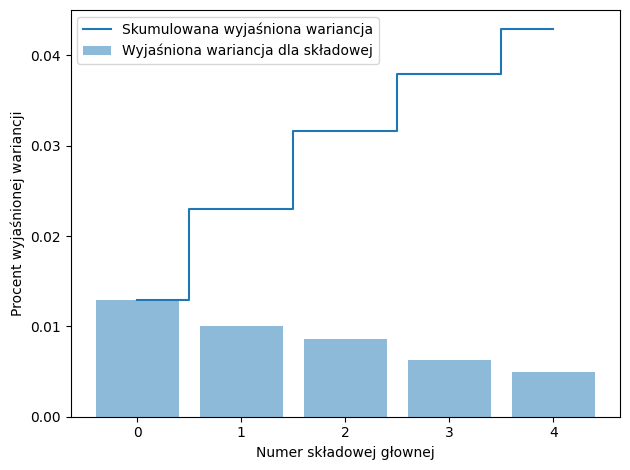

In [ ]:
exp_var_pca = model_knn.explained_variance_ratio_
print(exp_var_pca.sum())
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Wyjaśniona wariancja dla składowej')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Skumulowana wyjaśniona wariancja')
plt.ylabel('Procent wyjaśnionej wariancji')
plt.xlabel('Numer składowej głownej')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
y_prob_knn=knn_pca_cv.predict_proba(X_test)[:,1]

In [ ]:
save_probs_to_txt(y_prob_knn, 'probs_knn_pca0.txt')

# 2. Modele wykonane automatycznie uzywając pakietów AutoML.

In [ ]:
!pip install flaml

In [ ]:
from flaml import AutoML

AutoML model puszczony na 200 s

In [ ]:

automl_2 = AutoML()
automl_2.fit(X_train, np.asarray(y_train), task="classification", time_budget=200)

In [ ]:
print('Best accuracy on validation data: {0:.4g}'.format(1-automl_2.best_loss))

Best accuracy on validation data: 0.9489


In [ ]:
print("\n The best estimator:\n",automl_2.best_estimator)
print("\n The best hyperparameters configuration:\n",automl_2.best_config)
print('Training duration of best run: {0:.4g} s'.format(automl_2.best_config_train_time))


 The best estimator:
 lgbm

 The best hyperparameters configuration:
 {'n_estimators': 67, 'num_leaves': 103, 'min_child_samples': 10, 'learning_rate': 0.01625414597231461, 'log_max_bin': 9, 'colsample_bytree': 0.5101552633575213, 'reg_alpha': 0.056859676560214005, 'reg_lambda': 0.008615049094698365}
Training duration of best run: 3.068 s


In [ ]:
y_pred_flaml_200 = automl_2.model.predict_proba(X_test)[:,1]
save_probs_to_txt(y_pred_flaml_200, 'y_pred_flaml_200.txt')

Model puszczony na pół godziny:

In [ ]:
automl_3 = AutoML()
automl_3.fit(X_train, np.asarray(y_train), task="classification", time_budget=1800)

In [ ]:
print('Best accuracy on validation data: {0:.4g}'.format(1-automl_3.best_loss))

Best accuracy on validation data: 0.9282


In [ ]:
print("\n The best estimator:\n",automl_3.best_estimator)
print("\n The best hyperparameters configuration:\n",automl_3.best_config)
print('Training duration of best run: {0:.4g} s'.format(automl_3.best_config_train_time))


 The best estimator:
 extra_tree

 The best hyperparameters configuration:
 {'n_estimators': 503, 'max_features': 1.0, 'max_leaves': 598, 'criterion': 'entropy'}
Training duration of best run: 36.09 s
